# Pre-Processing of Data

In [1]:
# Misc
import os

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Sanity check for jupyter notebooks
print("Current working directory:", os.getcwd())

Current working directory: /drive


# Loading the dataframe
We load the full data and the recorded break up times.
Then we process it and merge them.

In [2]:
Data=pd.read_csv("Time_series_DATA.txt",
                 index_col=0,
                 sep=',',
                 skiprows=149,
                 parse_dates = True)
BreakUps = pd.read_csv("BreakUpTimes.csv")

In [3]:
# Drop all years before 1917
Data2 = Data[Data.index.year >= 1917].copy()
# Merge rows with duplicate index
# We assume here that when merging we only merge data with NaN, so the mean doesn't matter
grouped = Data2.groupby(Data2.index).mean()

In [4]:
# Process Break Up Times dataframe
BreakUps2 = BreakUps.copy()
BreakUps2['date'] = pd.to_datetime(BreakUps2[['Year','Month','Day','Hour','Minute']])
BreakUps2.set_index('date', inplace=True)
BreakUps2.drop(columns=['Year','Month','Day','Hour','Minute','datetime'], inplace=True)

In [5]:
# Process DATA dataframe
grouped['Days since start of year'] = grouped.index.dayofyear

In [6]:
# !!This cell takes some time to run!!
# Add a new column to grouped
grouped['days_since_matching_year'] = pd.NA

# Iterate over rows of grouped
for index, row in grouped.iterrows():
    year = index.year
    matching_date = BreakUps2[BreakUps2.index.year == year].index
    if not matching_date.empty:
        grouped.at[index, 'days_since_matching_year'] = (index - matching_date[0]).days

In [7]:
# Calculate the cumulative sum of differences to -5
grouped['Temp_Diff'] = grouped['Nenana: Air temperature [C]'] - (-5)
grouped['Cumulative_Diff'] = grouped['Temp_Diff'].clip(lower=0).groupby(grouped.index.year).cumsum()
grouped['Cumulative_Diff no clip'] = grouped['Temp_Diff'].groupby(grouped.index.year).cumsum()

# Visualizing the dataframe


In [8]:
grouped.columns

Index(['Regional: Air temperature [C]', 'Days since start of year',
       'Days until break up', 'Predicted ice thickness [m]',
       'Noisy predicted ice thickness [m]', 'Nenana: Rainfall [mm]',
       'Nenana: Snowfall [mm]', 'Nenana: Snow depth [mm]',
       'Nenana: Mean water temperature [C]', 'Nenana: Mean Discharge [m3/s]',
       'Nenana: Air temperature [C]', 'Fairbanks: Average wind speed [m/s]',
       'Fairbanks: Rainfall [mm]', 'Fairbanks: Snowfall [mm]',
       'Fairbanks: Snow depth [mm]', 'Fairbanks: Air Temperature [C]',
       'IceThickness [cm]', 'Regional: Solar Surface Irradiance [W/m2]',
       'Regional: Cloud coverage [%]',
       'Global: ENSO-Southern oscillation index', ' Gulkana Temperature [C]',
       'Gulkana Precipitation [mm]',
       'Gulkana: Glacier-wide winter mass balance [m.w.e]',
       'Gulkana: Glacier-wide summer mass balance [m.w.e]',
       'Global: Pacific decadal oscillation index',
       'Global: Artic oscillation index', 'days_since_m

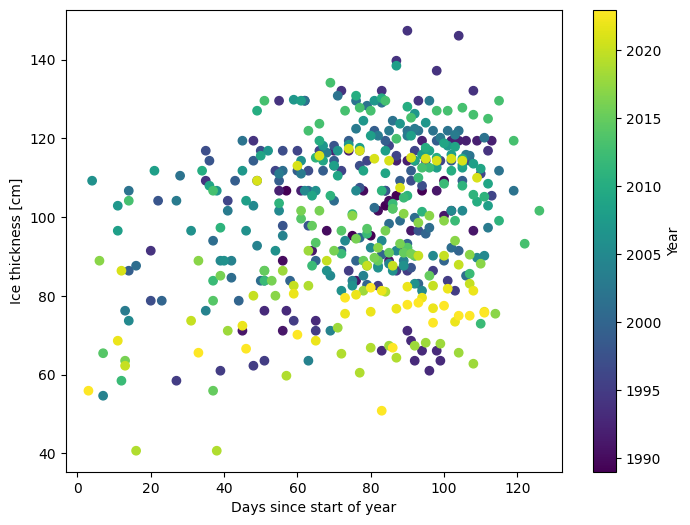

In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(grouped['Days since start of year'], grouped['IceThickness [cm]'], c=grouped.index.year, cmap='viridis')
plt.colorbar(scatter, label='Year')
plt.xlabel('Days since start of year')
plt.ylabel('Ice thickness [cm]')
plt.show()

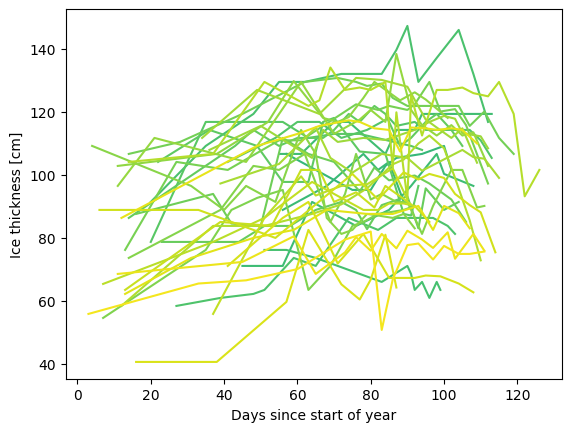

In [10]:
years = sorted(grouped.index.year.unique())
colors = cm.viridis([i / len(years) for i in range(len(years))])

fig, ax = plt.subplots()
for year, group, color in zip(years, grouped.groupby(grouped.index.year), colors):
    group = group[1][['Days since start of year','IceThickness [cm]']].dropna()
    ax.plot(group['Days since start of year'], group['IceThickness [cm]'], label=str(year), color=color)
ax.set_xlabel('Days since start of year')
ax.set_ylabel('Ice thickness [cm]')
plt.show()

(0.0, 400.0)

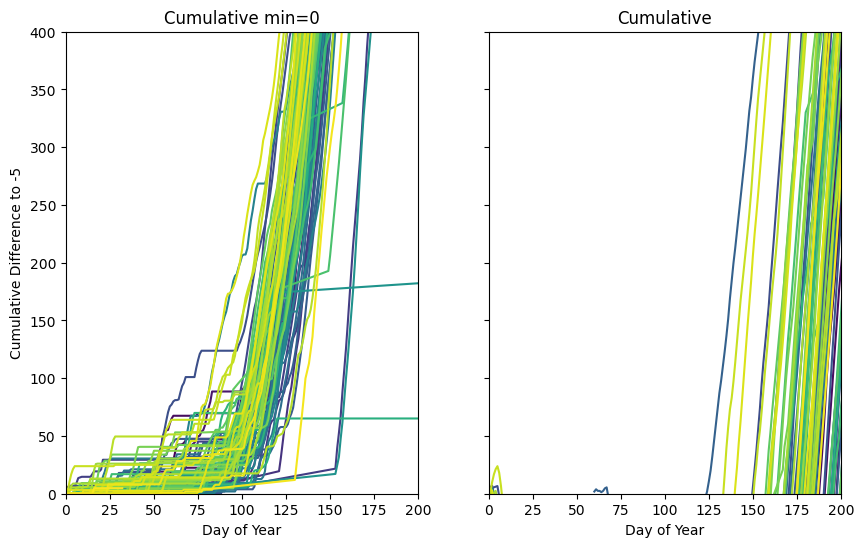

In [13]:
years = sorted(grouped.index.year.unique())
colors = cm.viridis([i / len(years) for i in range(len(years))])

fig, ax = plt.subplots(figsize=(10,6),ncols=2,sharey=True)

for year, group, color in zip(years, grouped.groupby(grouped.index.year), colors):
    group = group[1][['Nenana: Air temperature [C]','Cumulative_Diff','Cumulative_Diff no clip']].dropna()
    ax[0].plot(group.index.dayofyear, group['Cumulative_Diff'], label=str(year), color=color)
    ax[1].plot(group.index.dayofyear, group['Cumulative_Diff no clip'], label=str(year), color=color)
    
ax[0].set_title('Cumulative min=0')
ax[1].set_title('Cumulative')
ax[0].set_xlabel('Day of Year')
ax[1].set_xlabel('Day of Year')
ax[0].set_ylabel('Cumulative Difference to -5')
ax[0].set_xlim(0,200)
ax[1].set_xlim(0,200)
ax[0].set_ylim(0,400)

Text(0, 0.5, 'Cumulative temperature difference')

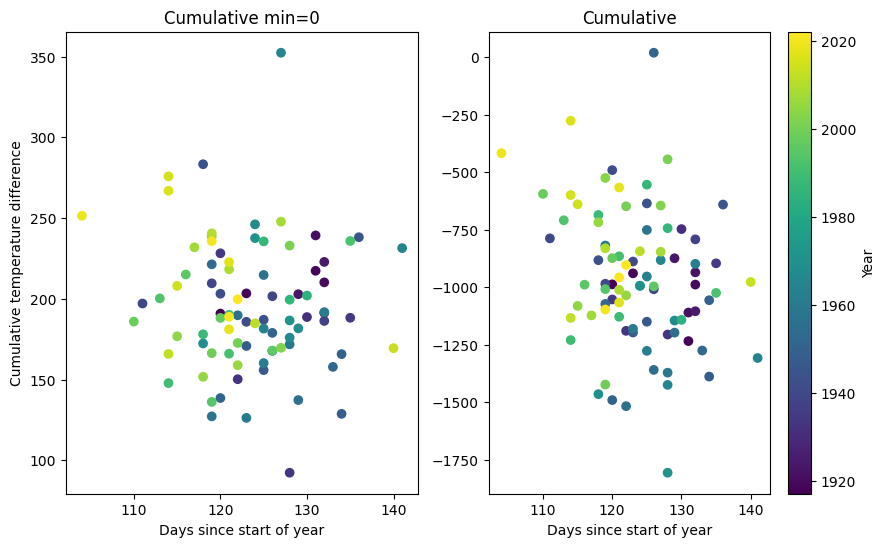

In [14]:
merged_df1 = pd.merge_asof(BreakUps2, grouped, left_index=True, right_index=True, direction='backward', allow_exact_matches=False)['Cumulative_Diff']
merged_df2 = pd.merge_asof(BreakUps2, grouped, left_index=True, right_index=True, direction='backward', allow_exact_matches=False)['Cumulative_Diff no clip']

fig, ax = plt.subplots(figsize=(10,6),ncols=2, sharey=False)

scatter1 = ax[0].scatter(merged_df1.index.dayofyear,merged_df1.values,c=merged_df1.index.year, cmap='viridis')
scatter1 = ax[1].scatter(merged_df2.index.dayofyear,merged_df2.values,c=merged_df2.index.year, cmap='viridis')
fig.colorbar(scatter1, label='Year',ax=ax[1])
ax[0].set_title('Cumulative min=0')
ax[1].set_title('Cumulative')
ax[0].set_xlabel('Days since start of year')
ax[1].set_xlabel('Days since start of year')
ax[0].set_ylabel('Cumulative temperature difference')